### Your name:

<pre> Rishab Kamshetty </pre>

### Collaborators:

<pre> Ashutosh Deowanshi </pre>


In this assignment you will train different models on a given data set, and find the one that performs best

### Getting the data for the assignment (similar to the notebook you have seen in class)

In [62]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [63]:
fetch_housing_data()

In [64]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [65]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [66]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [67]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [68]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [69]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [70]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


# ASSIGNMENT

### 1. Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [71]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing,train_size=0.7, test_size=0.3,random_state=47)
print(len(train_set),len(test_set))

14447 6192


### Features

In [72]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [73]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### 2. Polynomial transformations

Use PolynomialFeatures from sklearn.preprocessing

In [74]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit(X_tr)
X_tr = poly.transform(X_tr)
X_te = poly.transform(X_te)
print(str(X_tr.shape),str(X_te.shape))

(14447, 136) (6192, 136)


##### You should obtain X_tr and X_te with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$. Why?

##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

In [75]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


### 3. Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)
scaler.fit_transform(X_tr)
scaler.transform (X_te)

array([[ 0.        ,  0.94655253, -1.01023863, ..., -0.35513449,
         0.        , -0.38215385],
       [ 0.        , -0.84381922,  1.09140795, ..., -0.35513449,
         0.        , -0.38215385],
       [ 0.        ,  0.53646738, -0.75222399, ..., -0.35513449,
         0.        , -0.38215385],
       ...,
       [ 0.        ,  0.64649023, -0.76629751, ..., -0.35513449,
         0.        , -0.38215385],
       [ 0.        ,  0.5514705 , -0.75222399, ..., -0.35513449,
         0.        , -0.38215385],
       [ 0.        , -0.3337133 ,  1.74348133, ..., -0.35513449,
         0.        , -0.38215385]])

#### Comparing models

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 4. Linear regression on original features (no transformations) --- benchmark

#### Your goal is to find the model that minimizes the rmse score

In [78]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69457.70356115 68373.10151962 67990.13265268 67282.08614695]
Mean: 68275.75597009811


### 5. Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in 4 but with the transformed features (136 features)

In [79]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(),X_tr,np.ravel(y_tr), scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1.37904205e+16 8.12136647e+15 2.46848658e+15 4.41772394e+05]
Mean: 6095068388605161.0


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 6. Ridge regression

In [80]:
from sklearn.linear_model import Ridge
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_rr = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [81]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 1000}
66440.58508730112


### 7. Lasso regression

Now do the same as in 6 but with Lasso

In [82]:
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings(action="ignore")

param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000]}]

grid_search_lr = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [83]:
print(grid_search_lr.best_params_ , 'Alpha for param')
print(np.sqrt(-grid_search_lr.best_score_))

{'alpha': 1000} Alpha for param
66382.38603919715


### 8. Elastic Net regression

Do the same as in 6 and 7, but now with Elastic Net. However, the grid search should be over the parameters alpha and  l 1ratio. Use just 3 values for l1_ratio.

In [84]:
from sklearn.linear_model import ElasticNet
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000],
              'l1_ratio': [0.2, 0.5, 0.7]}]
grid_search_enr = GridSearchCV(ElasticNet(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_enr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'l1_ratio': [0.2, 0.5, 0.7]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [85]:
print(grid_search_enr.best_params_ , 'Elastic net alpha' )
print(np.sqrt(-grid_search_enr.best_score_))

{'alpha': 0.1, 'l1_ratio': 0.7} Elastic net alpha
65652.41766284549


### Evaluating your best model on TESTING data

Choose among grid_search_rr, grid_search_lr, and grid_search_enr, the model with best performance

In [86]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_enr.best_estimator_   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

66157.54978757279


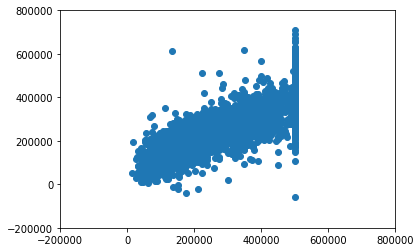

In [87]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rr.best_estimator_   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

66623.95915256049


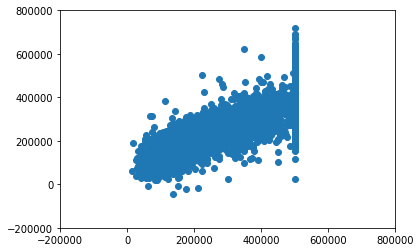

In [89]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

In [90]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_lr.best_estimator_   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

67489.6681902364


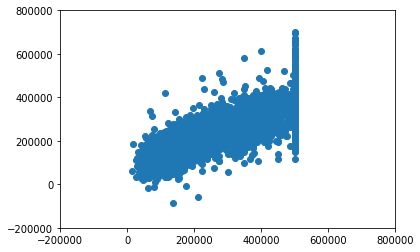

In [91]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

**Q1: Before you computed the final_rmse on the test data, what was your expected value for this quantity? Does your best model have high variance?**

<pre> 
Our best model is Elastic net regression because, when we do RMSE on training set, we get 65652.41766284549
And on RMSE on Test set is 66157.54978757279

As there is no much difference therefore, best model doesn't have high variance</pre>

### Submit your notebook

Submit your solution on Canvas